# SETING UP THE ENVIRONMENT

In [45]:
# ------------ 1. Mount Google Drive ------------
from google.colab import drive
drive.mount('/content/drive')

# ------------ 2. Check runtime type ------------
import subprocess, json, os, sys, torch, platform, textwrap
if not torch.cuda.is_available():
    print(
        "\n No GPU detected!"
    )

# ------------ 3. Upgrade pip & install libraries ------------
!pip -q install --upgrade pip

# Core DL frameworks (choose ONE; comment the other)
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # PyTorch 2.x CUDA 12
# !pip -q install tensorflow==2.16.1 tensorflow-io==0.40.0 tensorflow-addons==0.23.0             # TensorFlow 2.16

# Detection (YOLOv8) – works for either framework
!pip -q install ultralytics

# OCR baseline (EasyOCR, Pillow, Levenshtein for later metrics)
!pip -q install easyocr python-Levenshtein

print("\n Environment ready!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Environment ready!


# Data Preparation & Quick Label Visualisation

## Set paths & collect file lists

In [ ]:
#  paths
IMAGES_DIR = '/content/drive/MyDrive/NumberPlateData/Cars'
LABELS_DIR = '/content/drive/MyDrive/NumberPlateData/Labels'

# collect images
import glob, os, re
from pathlib import Path

image_paths = sorted(
    glob.glob(os.path.join(IMAGES_DIR, '*.[jp][pn]g'))
)
print(f"Found {len(image_paths)} images")

# matching label paths
label_paths = [
    Path(p).with_suffix('.txt').as_posix().replace('/Cars', '/Labels')
    for p in image_paths
]

# check that every image has a label file
missing = [p for p in label_paths if not os.path.exists(p)]
if missing:
    print("❌ Images with no label:", missing[:5], "…")
else:
    print("☑️ Every image has a corresponding .txt label")


Found 237 images
☑️ Every image has a corresponding .txt label


## Helper to read YOLO labels

In [ ]:
def load_yolo_labels(txt_path):
    """
    Reads a YOLO-format .txt file.
    Returns a list of [class_id, x_center, y_center, width, height] floats.
    All coords are normalised 0-1.
    """
    with open(txt_path, 'r') as f:
        lines = [l.strip() for l in f if l.strip()]
    boxes = [list(map(float, l.split())) for l in lines]
    return boxes


##  Visualise a random sample

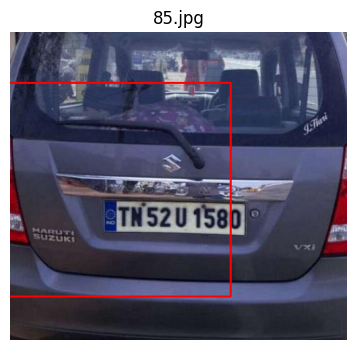

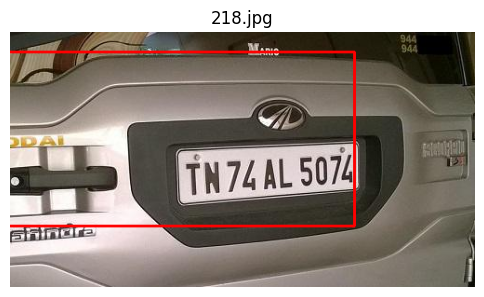

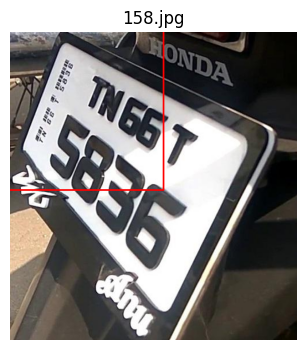

In [28]:
def show_sample_fixed(idx=None):
    if idx is None:
        idx = random.randrange(len(image_paths))

    # Load image
    img_path = image_paths[idx]
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # Draw bounding boxes from YOLO labels
    boxes = load_yolo_labels(label_paths[idx])
    for cls, xc, yc, bw, bh in boxes:
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.title(Path(img_path).name)
    plt.axis('off')
    plt.show()

# show
for _ in range(3):
    show_sample_fixed()


## (Visualize with Correct Boxes)

In [29]:
# checking if normalized or not the box was bit off
#  detect label format
def detect_label_format(samples=20):
    vals = []
    for p in label_paths[:samples]:
        for _, xc, yc, bw, bh in load_yolo_labels(p):
            vals += [xc, yc, bw, bh]
    max_val = max(vals)
    return "pixels" if max_val > 1.0 else "normalized"

fmt = detect_label_format()
print(f" Detected label format: {fmt}")


 Detected label format: normalized


### now that looks fair

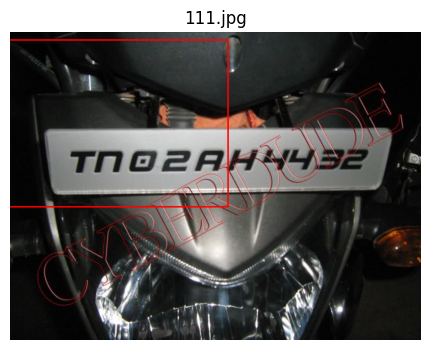

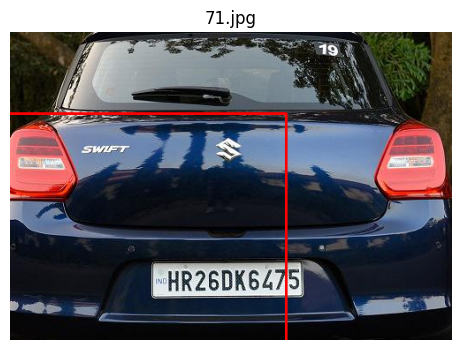

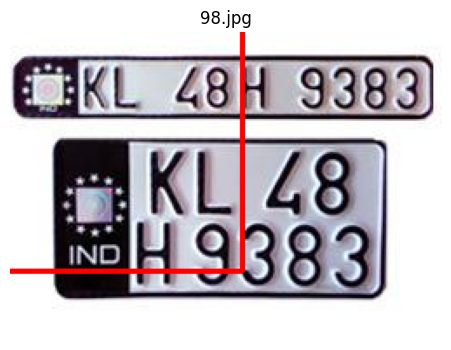

In [30]:
def show_sample_pixel_or_norm(idx=None):
    if idx is None:
        idx = random.randrange(len(image_paths))

    img_path = image_paths[idx]
    img_bgr  = cv2.imread(img_path)
    img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w     = img_rgb.shape[:2]

    # Decide on formula per label format
    pixel_labels = (fmt == "pixels")

    for cls, xc, yc, bw, bh in load_yolo_labels(label_paths[idx]):
        if pixel_labels:
            # pixel units directly
            x1 = int(xc - bw / 2)
            y1 = int(yc - bh / 2)
            x2 = int(xc + bw / 2)
            y2 = int(yc + bh / 2)
        else:
            # normalised 0‑1 (YOLO)
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)

        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.title(Path(img_path).name)
    plt.axis('off')
    plt.show()

# lets Try again
for _ in range(3):
    show_sample_pixel_or_norm()


# Split dataset & create data.yaml for YOLOv8

In [31]:
import os, shutil
from sklearn.model_selection import train_test_split

# New base directory for YOLO-ready dataset
YOLO_DIR = '/content/drive/MyDrive/NumberPlateDataYOLO'
os.makedirs(YOLO_DIR, exist_ok=True)

# Create required folders
for t in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    os.makedirs(os.path.join(YOLO_DIR, t), exist_ok=True)

#  Train/val split
train_imgs, val_imgs = train_test_split(image_paths, test_size=0.2, random_state=42)

# Helper fxn to copy image and its label
def copy_pair(src_img, split='train'):
    src_lbl = Path(src_img).with_suffix('.txt').as_posix().replace('/Cars', '/Labels')
    dst_img = os.path.join(YOLO_DIR, f'images/{split}', os.path.basename(src_img))
    dst_lbl = os.path.join(YOLO_DIR, f'labels/{split}', os.path.basename(src_lbl))
    shutil.copy2(src_img, dst_img)
    shutil.copy2(src_lbl, dst_lbl)

# Copy all
for img in train_imgs:
    copy_pair(img, 'train')
for img in val_imgs:
    copy_pair(img, 'val')

print(f"✅ Split done: {len(train_imgs)} train / {len(val_imgs)} val")


✅ Split done: 189 train / 48 val


## to Create data.yaml file

In [32]:
data_yaml = f"""
path: {YOLO_DIR}
train: images/train
val: images/val
nc: 1
names: ['number_plate']
""".strip()

with open(os.path.join(YOLO_DIR, 'data.yaml'), 'w') as f:
    f.write(data_yaml)

print(f"data.yaml written at: {YOLO_DIR}/data.yaml")


data.yaml written at: /content/drive/MyDrive/NumberPlateDataYOLO/data.yaml


# Train the numbeplate detector with YOLOv8

## sneak-peak

What happening:

a)Training logs will stream right in Colab.

b)At the end of every epoch YOLO saves best.pt (highest mAP50-95) and last.pt.

In [39]:
from ultralytics import YOLO
import torch, os, platform, time

# Extra safety checks
assert torch.cuda.is_available(), "GPU not detected – switch Colab runtime to GPU for faster output!"
assert os.path.exists('/content/drive/MyDrive/NumberPlateDataYOLO/data.yaml'), "data.yaml missing"

# Loaded a pretrained YOLOv8 nano model for transfer learning
model = YOLO('yolov8n.pt')   # swap with 'yolov8s.pt' etc. for larger models as per the requiremenent this was small dataset so used this

# Train
results = model.train(
    data='/content/drive/MyDrive/NumberPlateDataYOLO/data.yaml',
    epochs=50,
    imgsz=640,          # 640×640 input size
    batch=16,           # drop to 8 or 4 if you get OOM
    workers=4,
    project='number_plate_det',
    name='yolov8n_plate',
    exist_ok=True       # reuse folder if you rerun
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NumberPlateDataYOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_plate, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

train: Scanning /content/drive/MyDrive/NumberPlateDataYOLO/labels/train.cache... 189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 189/189 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 5.0±4.7 ms, read: 9.4±6.7 MB/s, size: 26.1 KB)


val: Scanning /content/drive/MyDrive/NumberPlateDataYOLO/labels/val.cache... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]


Plotting labels to number_plate_det/yolov8n_plate/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to number_plate_det/yolov8n_plate
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.2G      2.596      3.091      2.993         26        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         48         48    0.00326      0.979     0.0703     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.33G      2.196      2.848      2.383         28        640: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         48         48    0.00326      0.979       0.31     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.33G      2.017       2.71      2.247         31        640: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         48         48    0.00326      0.979      0.261      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.33G      1.975      2.585      2.203         42        640: 100%|██████████| 12/12 [00:03<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         48         48    0.00333          1     0.0561     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.33G      1.884      2.467      2.124         33        640: 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         48         48      0.179      0.396      0.182     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.33G      1.904      2.432      2.122         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         48         48      0.138      0.188      0.128     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.34G      1.933      2.328      2.174         27        640: 100%|██████████| 12/12 [00:03<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         48         48      0.246      0.396      0.251     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.34G      1.895      2.326      2.143         32        640: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         48         48      0.246      0.354      0.192     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.36G      1.841      2.191      2.071         38        640: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         48         48      0.192      0.479      0.213     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.36G      1.823       2.08      2.012         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         48         48      0.199      0.521      0.236      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.36G      1.834      2.064      2.014         30        640: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         48         48      0.178        0.5      0.221     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.36G      1.818      2.094      2.044         35        640: 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         48         48       0.42      0.583      0.518      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.36G      1.745      2.035      2.017         30        640: 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         48         48      0.493      0.729      0.592      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G      1.799      2.031      2.039         35        640: 100%|██████████| 12/12 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         48         48      0.364      0.521      0.377      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.37G       1.64      1.968      1.926         39        640: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         48         48      0.535      0.562      0.565      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.39G      1.669      1.866      1.957         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         48         48      0.716      0.577      0.679      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.39G      1.672      1.817      1.946         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         48         48      0.389       0.75      0.498      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.39G      1.667      1.856      1.921         34        640: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         48         48      0.628      0.562      0.618      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.39G      1.649      1.777      1.894         31        640: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         48         48      0.529      0.583      0.537      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G      1.644      1.802      1.885         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         48         48      0.337      0.583      0.395      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.41G      1.593      1.762      1.883         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         48         48      0.564      0.771      0.634      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.41G      1.611      1.766      1.864         37        640: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         48         48      0.666      0.624      0.666      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.41G      1.624      1.819      1.871         37        640: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         48         48      0.859      0.637      0.741      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.41G      1.527      1.674      1.819         34        640: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         48         48      0.663      0.646      0.683      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.41G      1.561      1.644      1.815         25        640: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         48         48      0.536      0.625      0.535      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.41G      1.532      1.544      1.784         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         48         48      0.684      0.722      0.753      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.41G      1.549       1.62      1.817         34        640: 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         48         48      0.751       0.75      0.743      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.41G      1.521      1.507      1.763         31        640: 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         48         48      0.813      0.667      0.777       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.41G      1.512      1.575      1.812         30        640: 100%|██████████| 12/12 [00:03<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         48         48      0.913      0.604      0.785      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.41G      1.567      1.527      1.795         37        640: 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         48         48      0.719      0.639       0.78      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.41G      1.541      1.577      1.786         36        640: 100%|██████████| 12/12 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         48         48      0.723      0.545      0.704      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.41G      1.511      1.589      1.755         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         48         48      0.779      0.646       0.71       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.41G      1.446      1.532      1.744         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         48         48      0.671      0.764      0.758      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.41G      1.421      1.493      1.723         31        640: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


                   all         48         48      0.716      0.583      0.679      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.41G      1.454      1.522      1.759         43        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         48         48      0.726      0.667      0.714      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.41G      1.428      1.414      1.718         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         48         48      0.735      0.694      0.713      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.41G      1.397       1.38      1.657         36        640: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         48         48      0.686       0.75       0.73      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.41G      1.395      1.396      1.678         42        640: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         48         48      0.849      0.729      0.797      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.41G      1.335      1.266      1.639         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         48         48      0.842      0.771      0.846      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.41G      1.354      1.374      1.677         30        640: 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         48         48       0.88      0.761      0.865      0.526


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.41G       1.23      1.297      1.686         13        640: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         48         48      0.866      0.812      0.842      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.41G      1.128      1.109       1.57         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         48         48      0.887      0.792      0.852       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.41G      1.114      1.076      1.603         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         48         48      0.947      0.743      0.844       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.41G      1.023      0.999      1.529         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         48         48      0.923      0.749      0.826      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.41G      0.993     0.9336      1.531         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         48         48       0.78      0.811       0.81      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.41G     0.9639     0.9464      1.459         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         48         48       0.78      0.771        0.8      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.41G     0.9962      0.909      1.567         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         48         48      0.793      0.771      0.812      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.41G     0.9618     0.9232      1.454         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         48         48      0.863      0.789      0.833       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.41G      0.928     0.8494      1.445         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         48         48      0.857      0.792      0.841      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.41G     0.9153      0.861      1.464         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         48         48      0.864      0.791      0.854      0.592



50 epochs completed in 0.065 hours.
Optimizer stripped from number_plate_det/yolov8n_plate/weights/last.pt, 6.3MB
Optimizer stripped from number_plate_det/yolov8n_plate/weights/best.pt, 6.3MB

Validating number_plate_det/yolov8n_plate/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         48         48      0.857      0.792      0.841      0.596
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to number_plate_det/yolov8n_plate


# Evaluation & Metrics

In [40]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np

BEST_PT = '/content/number_plate_det/yolov8n_plate/weights/best.pt'
model   = YOLO(BEST_PT)

# validate
metrics = model.val(data='/content/drive/MyDrive/NumberPlateDataYOLO/data.yaml')

# Convenience: pull arrays -> scalars
precision = float(np.mean(metrics.box.p))       # mean over classes (1 class here)
recall    = float(np.mean(metrics.box.r))
map50     = float(metrics.box.map50)
map5095   = float(metrics.box.map)

print(f"📦 Precision:     {precision:.3f}")
print(f"📦 Recall:        {recall:.3f}")
print(f"📦 map20:       {map50:.3f}")
print(f"📦 map5095:  {map5095:.3f}")

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 12.8±3.0 MB/s, size: 19.8 KB)


val: Scanning /content/drive/MyDrive/NumberPlateDataYOLO/labels/val.cache... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


                   all         48         48      0.852      0.792      0.846      0.596
Speed: 6.9ms preprocess, 4.6ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/val7
📦 Precision:     0.852
📦 Recall:        0.792
📦 map20:       0.846
📦 map5095:  0.596


# End to end test: Detect -> Crop-> OCR

In [41]:
from ultralytics import YOLO
import cv2, matplotlib.pyplot as plt
from pathlib import Path

# Load best detector weights
DETECTOR = YOLO('/content/number_plate_det/yolov8n_plate/weights/best.pt')

# Choose a folder of test images (here, the val split)
TEST_DIR = Path('/content/drive/MyDrive/NumberPlateDataYOLO/images/val')
test_paths = sorted(list(TEST_DIR.glob('*.[jp][pn]g')))
print(f"{len(test_paths)} test images loaded")


48 test images loaded


In [42]:
def detect_and_crop(img_path, conf_thres=0.25):
    """Return list of (crop_BGR, xyxy) per detected plate."""
    results = DETECTOR(img_path, conf=conf_thres)[0]   # first (and only) image
    crops = []
    if results.boxes is None or len(results.boxes) == 0:
        return crops

    img_bgr = cv2.imread(str(img_path))
    h, w = img_bgr.shape[:2]

    for box in results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        # Clamp to image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w - 1, x2), min(h - 1, y2)
        crop = img_bgr[y1:y2, x1:x2]
        crops.append((crop, (x1, y1, x2, y2)))
    return crops



image 1/1 /content/drive/MyDrive/NumberPlateDataYOLO/images/val/166.jpg: 384x640 (no detections), 30.8ms
Speed: 8.0ms preprocess, 30.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
No plate detected

image 1/1 /content/drive/MyDrive/NumberPlateDataYOLO/images/val/40.jpg: 448x640 2 number_plates, 15.5ms
Speed: 4.3ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


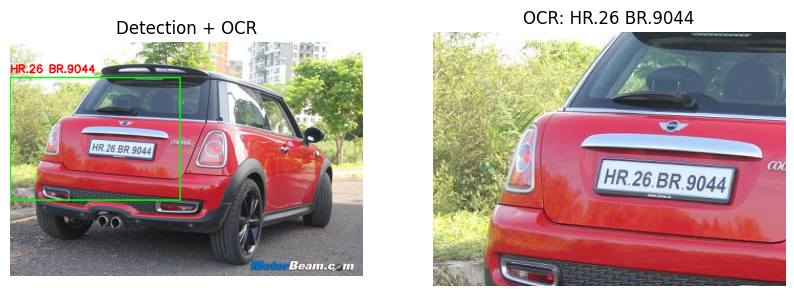


image 1/1 /content/drive/MyDrive/NumberPlateDataYOLO/images/val/85.jpg: 608x640 1 number_plate, 88.9ms
Speed: 10.9ms preprocess, 88.9ms inference, 2.3ms postprocess per image at shape (1, 3, 608, 640)


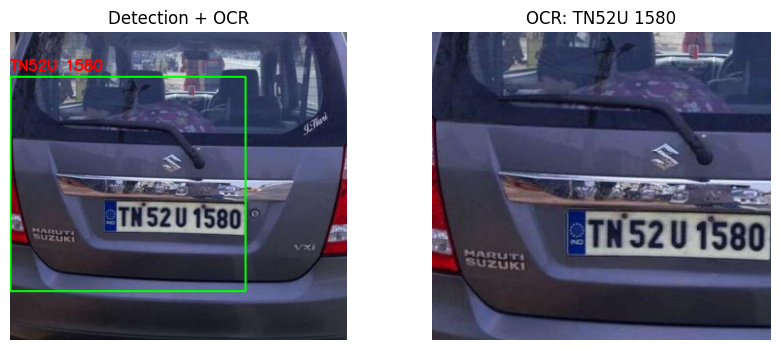

In [46]:
import easyocr
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

def show_prediction(img_path):
    crops = detect_and_crop(img_path)
    if not crops:
        print("No plate detected")
        return

    # OCR on first detected plate
    plate_bgr, (x1, y1, x2, y2) = crops[0]
    ocr_result = reader.readtext(plate_bgr, detail=0, paragraph=False)
    plate_text = ocr_result[0] if ocr_result else '???'

    # Draw box + text on original image
    img_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img_rgb, plate_text, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    # Show both
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_rgb); plt.axis('off'); plt.title('Detection + OCR')
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f'OCR: {plate_text}')
    plt.show()

# Try on 3 random images
import random
for p in random.sample(test_paths, 3):
    show_prediction(p)


In [44]:
# Copy final model weights to Drive
!cp /content/number_plate_det/yolov8n_plate/weights/best.pt \
    /content/drive/MyDrive/NumberPlateDetectorFinal.pt
print(" Model exported to Drive as NumberPlateDetectorFinal.pt")


 Model exported to Drive as NumberPlateDetectorFinal.pt
